In [165]:
import pandas as pd
import numpy as np
from fredapi import Fred
import yfinance as yf
from arch.bootstrap import MovingBlockBootstrap
import matplotlib.pyplot as plt
import warnings
import retirement
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
initial_pay: int = 120000
start_age: int = 31
end_of_life: int = 81
periods: int = end_of_life - start_age

In [168]:
api_key: str = "7e2c091b908b044128b6aa56c3433a5f"  # Replace with your FRED API key
fred: Fred = Fred(api_key=api_key)

In [169]:
# Fetch core inflation data (e.g., Core Consumer Price Index, CPI)
resample = "YE"
core_cpi_data: pd.Series = fred.get_series("CPILFESL")
cpi_pct_change: pd.Series = core_cpi_data.resample(resample).last().pct_change()
cpi_pct_change = cpi_pct_change.loc['1960-01-01':]

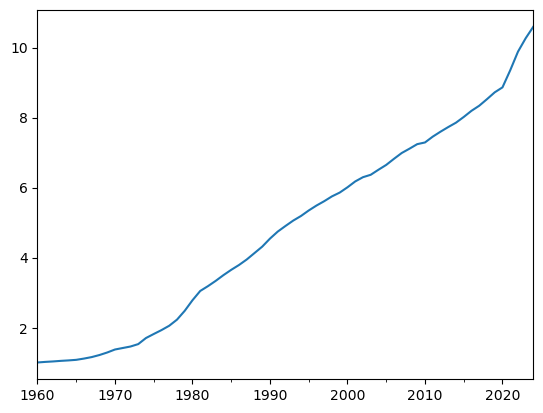

In [170]:
(1+cpi_pct_change).cumprod().plot();

In [171]:
# CPI autocorrelation
np.abs(np.array([cpi_pct_change.autocorr(x) for x in range(1, 20)]))

array([0.79515069, 0.59500893, 0.49311798, 0.51886368, 0.50618182,
       0.43596443, 0.31177612, 0.18248312, 0.18308038, 0.2217912 ,
       0.19187518, 0.04968467, 0.06372368, 0.15333075, 0.18764648,
       0.22881602, 0.27913501, 0.34405792, 0.37112559])

In [172]:
mbb = MovingBlockBootstrap(8, cpi_pct_change)
inflation_bootstrap_samples = [data[0][0].to_frame().reset_index(drop=True) for data in mbb.bootstrap(100)]
inflation_bs_samples_df = pd.concat(inflation_bootstrap_samples, axis=1)

In [173]:
inflation_bs_samples_df.index = cpi_pct_change.index
preds = inflation_bs_samples_df.add(1).cumprod()

In [174]:
pd.DataFrame(preds.values - (1+cpi_pct_change).cumprod().values.reshape(-1, 1)).iloc[-1].describe()

count   100.00
mean      3.03
std       7.55
min      -6.03
25%      -1.64
50%       1.21
75%       5.84
max      46.14
Name: 64, dtype: float64

In [175]:
np.sqrt(np.mean(((1+cpi_pct_change).cumprod() - preds.mean(axis=1)).dropna()**2))

1.1478462270010101

<AxesSubplot: >

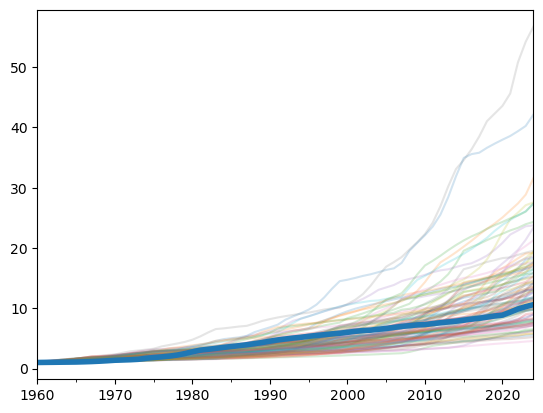

In [176]:
# inflation_bs_samples_df.index = cpi_pct_change.loc['2000':'2020'].index
inflation_bs_samples_df.add(1).cumprod().plot(legend=False, alpha=.2)
(1+cpi_pct_change).cumprod().plot(linewidth=4)

<AxesSubplot: >

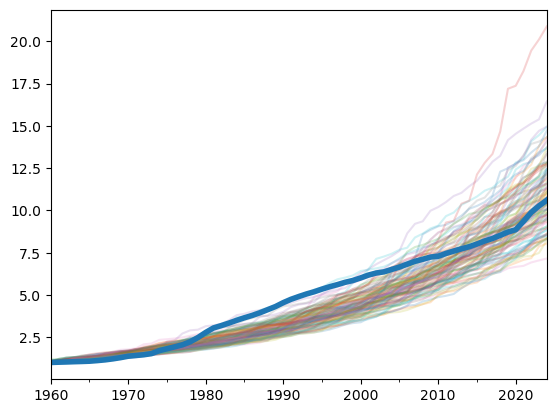

In [177]:
sims = []
for i in range(100):
    sim = pd.Series(np.random.lognormal(np.log(cpi_pct_change).mean(), np.log(cpi_pct_change).std(), len(cpi_pct_change))).add(1).cumprod()
    sim.index = cpi_pct_change.index
    sims.append(sim.to_frame())
    sim.plot(alpha=.2)
(1+cpi_pct_change).cumprod().plot(linewidth=4)

In [178]:
preds = pd.concat(sims, axis=1).mean(axis=1)

In [179]:
pd.DataFrame(preds.values - (1+cpi_pct_change).cumprod().values.reshape(-1, 1)).iloc[-1].describe()

count   65.00
mean    -6.34
std      2.84
min     -9.56
25%     -8.72
50%     -7.20
75%     -4.48
max      0.42
Name: 64, dtype: float64

In [180]:
np.sqrt(np.mean(((1+cpi_pct_change).cumprod() - preds)**2))

0.8850556574667433

In [181]:
sp500: pd.DataFrame = yf.download('^GSPC', start='1970-01-01', end='2025-01-01', progress=False)
sp500_pct_change: pd.Series = sp500['Adj Close'].pct_change().resample(resample).sum()

In [182]:
# Correlation between historical sp500 and inflation
pd.merge(sp500_pct_change.to_frame(),
         cpi_pct_change.rename("cpi").to_frame().rename_axis(index="Date"),
         right_index=True,
         left_index=True).corr().abs().iloc[0, 1]

0.17286447332688312

In [183]:
# SP500 autocorrelation
np.abs(np.array([sp500_pct_change.autocorr(x) for x in range(1, 10)]))

array([0.04426298, 0.18760799, 0.06255872, 0.15216794, 0.32536644,
       0.08434492, 0.20747599, 0.10210941, 0.18385364])

In [184]:
# pd.plotting.autocorrelation_plot(sp500_pct_change)
# plt.title("SP500 Autocorrelation");

In [185]:
# pd.plotting.autocorrelation_plot(cpi_pct_change)
# plt.title("CPI Autocorrelation");

In [186]:
mbb = MovingBlockBootstrap(8, cpi_pct_change)
inflation_bootstrap_samples = np.array([data[0] for data in mbb.bootstrap(500)])

In [187]:
retire_55 = []
retire_60 = []
retire_62 = []
for i in range(500):
    inflation: pd.Series = pd.Series(inflation_bootstrap_samples[i, 0][:periods])
    annual_income: pd.Series = ((1 + inflation.shift(1).fillna(0)).cumprod() * initial_pay)
    annual_income = annual_income.shift(1)
    annual_income[0:1] = [82000]
    stock_growth: pd.Series = sp500_pct_change[1:].sample(periods, replace=True).reset_index(drop=True)
    pepra_comp_limit: pd.Series = (1 + inflation.cumprod()) * 151446
    age = np.arange(start_age, start_age+periods)
    calpers_spreadsheet = pd.DataFrame()
    calpers_spreadsheet['age'] = age
    calpers_spreadsheet['annual_income'] = annual_income
    calpers_spreadsheet['calpers_benefit_factor'] = retirement.calpers_benefit_factor(age)
    calpers_spreadsheet['calpers_pct_income'] = retirement.calpers_pct_income(age, start_age)
    calpers_spreadsheet['calpers_benefit'] = retirement.calpers_benefit(age, start_age, calpers_spreadsheet['annual_income'])
    calpers_spreadsheet['post_retirement_income'] = annual_income - (
            retirement.roth_ira_contribution(annual_income) +
            retirement.trad_ira_contribution(annual_income) +
            retirement.calpers_contribution(annual_income)
        )
    roth_ira_balances, trad_ira_balances = retirement.ira_growth(annual_income, stock_growth, periods)
    calpers_spreadsheet['roth_ira_balances'] = roth_ira_balances
    calpers_spreadsheet['trad_ira_balances'] = trad_ira_balances
    calpers_spreadsheet['ira_benefit'] = (calpers_spreadsheet['roth_ira_balances'] + calpers_spreadsheet['trad_ira_balances']) / (calpers_spreadsheet['age'].max() - calpers_spreadsheet['age'])
    calpers_spreadsheet['inflation'] = (1 + inflation.values).cumprod()
    calpers_spreadsheet['retirement_benefit'] = (calpers_spreadsheet['ira_benefit'] + calpers_spreadsheet['calpers_benefit']) / calpers_spreadsheet['inflation']
    calpers_spreadsheet = calpers_spreadsheet.set_index('age')
    retire_55.append(calpers_spreadsheet.loc[55])
    retire_60.append(calpers_spreadsheet.loc[60])
    retire_62.append(calpers_spreadsheet.loc[62])

<AxesSubplot: >

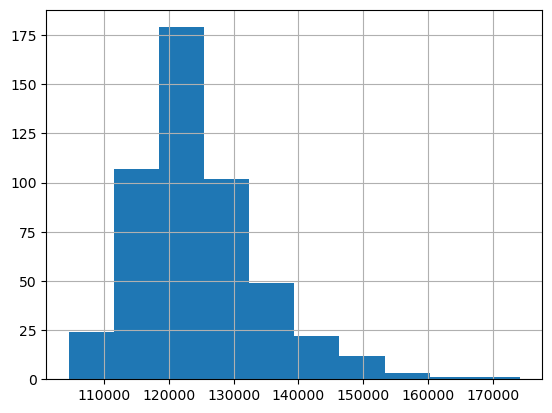

In [188]:
pd.Series([retire_55[i]['retirement_benefit'] for i in range(len(retire_60))]).hist()

In [189]:
pd.DataFrame(retire_55).describe()

,annual_income,calpers_benefit_factor,calpers_pct_income,calpers_benefit,post_retirement_income,roth_ira_balances,trad_ira_balances,ira_benefit,inflation,retirement_benefit
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,300769.25,0.01,1.00,300769.25,269707.71,566023.47,249191.38,32608.59,2.70,124466.50
std,85667.62,0.00,0.00,85667.62,78814.21,405583.06,134472.01,19048.24,0.79,9532.90
min,178811.32,0.01,1.00,178811.32,157506.42,23236.43,39441.30,3284.34,1.59,104574.73
25%,239533.56,0.01,1.00,239533.56,213370.87,269552.54,147743.98,18352.46,2.14,118255.05
50%,278483.72,0.01,1.00,278483.72,249205.02,475049.79,216215.70,29204.42,2.49,122775.55
75%,344090.65,0.01,1.00,344090.65,309563.40,746247.04,316083.03,41749.01,3.16,128829.77
max,718089.19,0.01,1.00,718089.19,653642.05,2988868.03,783744.32,147151.78,6.29,174189.99


In [190]:
pd.DataFrame(retire_60).describe()

,annual_income,calpers_benefit_factor,calpers_pct_income,calpers_benefit,post_retirement_income,roth_ira_balances,trad_ira_balances,ira_benefit,inflation,retirement_benefit
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,362319.89,0.02,1.00,362319.89,326334.30,879538.17,430328.22,65493.32,3.27,133247.36
std,108875.69,0.00,0.00,108875.69,100165.63,718513.48,257571.00,43848.95,1.02,17695.80
min,202178.19,0.02,1.00,202178.19,179003.94,15106.96,58105.42,4474.24,1.73,100833.32
25%,285149.78,0.02,1.00,285149.78,255337.80,375720.33,248904.06,33467.30,2.55,121524.58
50%,333543.00,0.02,1.00,333543.00,299859.56,692882.82,358786.59,53602.14,3.00,129254.05
75%,418359.24,0.02,1.00,418359.24,377890.50,1166372.51,531450.32,84561.26,3.74,140863.84
max,821529.13,0.02,1.00,821529.13,748806.80,5478267.65,1581176.64,318257.47,7.62,253852.77


<AxesSubplot: ylabel='Density'>

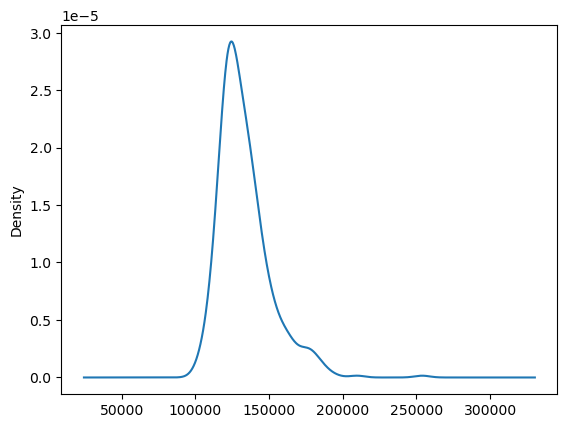

In [191]:
pd.DataFrame(retire_60)['retirement_benefit'].plot.kde()

<AxesSubplot: xlabel='inflation', ylabel='retirement_benefit'>

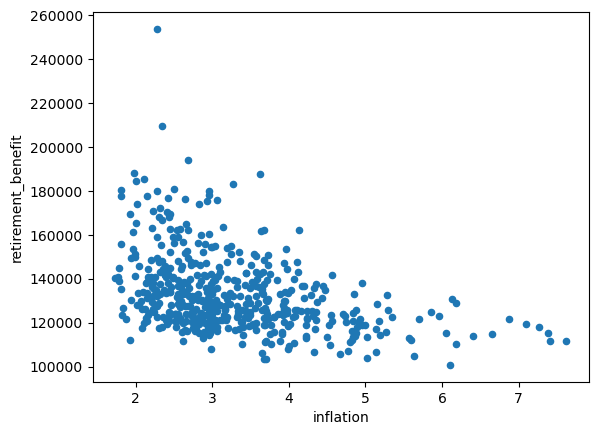

In [192]:
pd.DataFrame(retire_60).plot.scatter(x='inflation', y='retirement_benefit')

<AxesSubplot: >

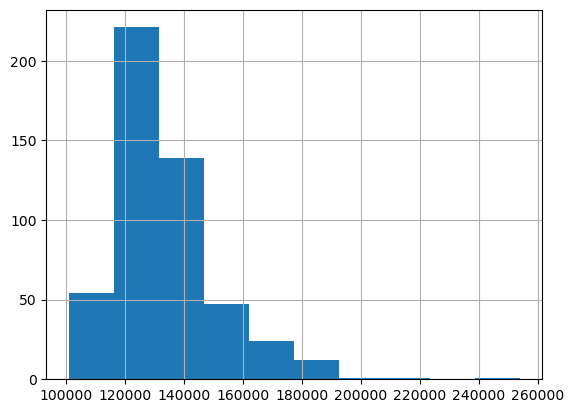

In [193]:
# pd.DataFrame(retire_55)['retirement_benefit'].hist()
# pd.DataFrame(retire_60)['retirement_benefit'].hist()
pd.DataFrame(retire_60)['retirement_benefit'].hist()

In [194]:
pd.DataFrame(retire_62)['retirement_benefit'].describe()

count      500.00
mean    138611.99
std      22973.42
min     101076.80
25%     123374.52
50%     132967.79
75%     147218.29
max     314099.96
Name: retirement_benefit, dtype: float64

In [195]:
main_spreadsheet = calpers_spreadsheet.copy()[
    ['annual_income', 'post_retirement_income', 'calpers_benefit', 'ira_benefit', 'retirement_benefit']
]

In [196]:
main_spreadsheet

,annual_income,post_retirement_income,calpers_benefit,ira_benefit,retirement_benefit
age,,,,,
31,82000.00,68440.00,0.00,673.47,657.34
32,120000.00,103400.00,0.00,923.82,885.05
33,122943.93,106108.41,0.00,1163.25,1086.47
34,125257.01,108236.45,0.00,950.06,863.33
35,128481.31,111202.80,0.00,1414.88,1260.94
36,132056.07,114491.59,0.00,1471.12,1296.89
37,134649.53,116877.57,0.00,1818.12,1567.29
38,136121.50,118231.78,0.00,2433.12,2053.99
39,139205.61,121069.16,0.00,3115.38,2464.09
